In [1]:
#| default_exp session_1

# 1. Session - MalariaGEN

> The first session about the notebook is about exploring `https://www.malariagen.net/`. 

MalariaGen.net is an online database that provides comprehensive genomic data on Plasmodium falciparum, the parasite that causes the most severe form of malaria in humans. The database was established by the Malaria Genomic Epidemiology Network (MalariaGEN), which is a global collaboration of researchers working towards understanding the genetic and molecular basis of malaria susceptibility, drug resistance, and transmission.

For more info:
https://www.malariagen.net/Publications , and specifically:
https://wellcomeopenresearch.org/articles/8-22/v1

The database includes information on the genetic diversity of the parasite, including data on single nucleotide polymorphisms (SNPs) and copy number variations (CNVs). It also provides information on the distribution of drug resistance mutations, which is critical for developing effective malaria treatments.

In addition to genomic data, MalariaGen.net also provides access to other types of data, including epidemiological and clinical data. These data are integrated with the genomic data to provide a comprehensive view of the malaria landscape, including information on the distribution of different malaria parasite strains and their associated clinical outcomes.

Overall, MalariaGen.net is an essential resource for researchers and public health officials working towards the goal of eliminating malaria. By providing open access to comprehensive genomic and epidemiological data, MalariaGen.net is helping to drive advances in our understanding of the biology of the malaria parasite and to inform the development of new and effective malaria control strategies.





## Outline

We'll be focussing on the pathogen P. falciparum.

![Alphonse Laveran was the first to identify the parasite in 1880, and named it Oscillaria malariae.](./images/laveran_malaria.jpg) 



1. Explore datasets available MalariaGEN related to P. falciparum   
    We will be looking specifically at the following resources, short variants (SNPs only) and metadata:   
        - 20,864 samples from 33 countries, but we will filter specifically for african countries (Kenya, ...)   
        - VCF accessable at: ftp://ngs.sanger.ac.uk/production/malaria/Resource/34/Pf7_vcf/ using i.e. FileZilla   
        - Filter version will be supplied due to large file sizes > 100 GBs (BCFTools)
        - Resistance status to drugs, like: Chloroquine, Pyrimethamine, Sulfadoxine, Mefloquine, Artemisinin, Piperaquine   
        - Other metadata, i.e. geographic location    


2. After downloading and filtering the data we can load them with the python package `scikit-allel`. Next, we will filter, based on the samples of our country of interest and build geneologies with `tsinfer`. Afterwards, we date the inferred geneologies and calculate summary statistics, like genetic diversity and Tajimas D.

## Analysis

In the following part of potential analysis path is shown, feel free to follow it and/or modify it.

### Metadata

In [2]:
#pip install requests pandas

In [3]:
# python package imports

import os, io, requests
from pathlib import Path
import pandas as pd
data_directory = Path("../data")


In [4]:
# Downloading samples information  
samples_url = "https://www.malariagen.net/sites/default/files/Pf7_samples.txt"
samples_metadata = pd.read_csv(io.StringIO(requests.get(samples_url).content.decode('utf-8')), sep="\t")
samples_metadata.head().iloc[:1]

,Sample,Study,Country,Admin level 1,Country latitude,Country longitude,Admin level 1 latitude,Admin level 1 longitude,Year,ENA,All samples same case,Population,% callable,QC pass,Exclusion reason,Sample type,Sample was in Pf6
0,FP0008-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081237,FP0008-C,AF-W,82.16,True,Analysis_set,gDNA,True


In [5]:
african_countries = ['Benin', 'Burkina Faso','Cameroon', 'Gabon' ,'Cameroon', 'Côte d\'Ivoire','Mozambique', 'Democratic Republic of the Congo','Sudan', 'Ethiopia', 'Gambia', 'Ghana', 'Guinea', 'Kenya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Nigeria', 'Senegal', 'Tanzania', 'Uganda']
non_african_countries = ['Bangladesh', 'Cambodia', 'Colombia', 'India', 'Indonesia', 'Laos', 'Myanmar', 'Papua New Guinea', 'Peru', 'Thailand', 'Venezuela', 'Vietnam']
african_subset = ['Kenya', 'Ethiopia', 'Tanzania', 'Uganda']

Next we identify the sample ids, which we want to explore:

In [6]:
# form sample table above create mask to filter the table to only contain rows of interest
samples_metadata_mask = [True if criteria in african_subset else False for criteria in samples_metadata.Country]
samples_metadata = samples_metadata[samples_metadata_mask]

# quality control filtering
samples_metadata = samples_metadata[samples_metadata["QC pass"]]

# we only look at genomic DNA (gDNA) for now
samples_metadata_mask = [True if criteria in ["gDNA"] else False for criteria in samples_metadata["Sample type"]]
samples_metadata = samples_metadata[samples_metadata_mask]

# reseting tables indices
samples_metadata = samples_metadata.reset_index(drop=True)

In [7]:
samples_metadata_kenya = samples_metadata[samples_metadata["Country"] == "Kenya"]

print(f"Number of gDNA samples in Kenya with QC pass True {samples_metadata_kenya.shape[0]}.")

Number of gDNA samples in Kenya with QC pass True 321.


Save Kenyan samples ids to txt file:


In [8]:
samples_ids = samples_metadata_kenya.Sample.tolist()
with open(data_directory/"kenyan_sample_ids.txt", "a") as f:
    for samples_id in samples_ids:
        f.write(samples_id + "\n")

## GFF file analysis

In [9]:
gff_path = Path("../data/Pfalciparum_replace_Pf3D7_MIT_v3_with_Pf_M76611.gff")
gff = pd.read_csv(gff_path, sep="\t", comment="#", header=None)

# renaming some columns
gff.columns = ["chr", 1, "region", "start", "end", 4, "strand", 5, "desc"]


# filtering for gene regions
gff_genes = gff[gff["region"] == "gene"]
gff_genes.reset_index(drop=True, inplace=True)

Next we extract genes related to resistance of Malaria drugs.

In [10]:
import re
loci_locations = []
locis = ["crt", "dhfr", "dhps", "mdr1", "Kelch13", "Plasmepsin"]
for loci in locis:
    pattern = 'Name=(.*' + loci.lower() +  '.*|.*' + loci.upper()  + '.*|' + loci + ').*;'
    mask = [True if len(re.findall(pattern, desc)) > 0 else False for desc in gff_genes["desc"]]
    loci_locations.append(gff_genes[mask])

loci_locations = pd.concat(loci_locations)
# Plasmepsin not found (mostlikely different name)
loci_locations.reset_index(drop=True, inplace=True)


In [11]:
for _, item in loci_locations.iterrows():
    print(item["chr"], item["start"], item["end"], item["end"] - item["start"],  item["desc"])


Pf3D7_07_v3 402385 406341 3956 ID=PF3D7_0709000;Name=CRT;previous_systematic_id=MAL7P1.27
Pf3D7_04_v3 747897 750065 2168 ID=PF3D7_0417200;Name=DHFR-TS;previous_systematic_id=PFD0830w,MAL4P1.161;synonym=PfDHFR-TS%3Bcurrent%3Dfalse
Pf3D7_08_v3 547896 551057 3161 ID=PF3D7_0810800;Name=PPPK-DHPS;previous_systematic_id=PF08_0095
Pf3D7_05_v3 955955 963095 7140 ID=PF3D7_0523000;Name=MDR1;previous_systematic_id=PFE1150w,MAL5P1.230;synonym=Pgh1,ABCB1
Pf3D7_13_v3 1724600 1727877 3277 ID=PF3D7_1343700;Name=Kelch13;previous_systematic_id=PF13_0238;synonym=K13


## Extracting gene region of interest from VCF file

To create a vcf file which contains only PASS bi-allelic coding SNPs with
VQSLOD > 6:

```console

bcftools view \
--include 'FILTER="PASS" && N_ALT=1 && CDS==1 && TYPE="snp" && VQSLOD>6.0' \
--regions Pf3D7_04_v3:600000-1000000 \
--output-type z \
--output-file DHFR-TS.vcf.gz \
Pf3D7_04_v3.pf7.vcf.gz
bcftools index --tbi DHFR-TS.vcf.gz
```

## Loading resistance status metadata

In [20]:
kenyian_samples = pd.read_csv(data_directory/"kenyan_sample_ids.txt", header=None)[0].tolist()

In [31]:
sample

'PC0003-01'

In [35]:
resistance_url = "https://www.malariagen.net/sites/default/files/Pf7_inferred_resistance_status_classification.txt"
resistance_status = pd.read_csv(io.StringIO(requests.get(resistance_url).content.decode('utf-8')), sep="\t")

resistent_samples = []
sensitive_samples = []
undetermined_samples = []

for sample in kenyian_samples:
    sulfadoxine = resistance_status[resistance_status["Sample"] == sample]["Sulfadoxine"]
    if len(sulfadoxine) == 1:
        sulfadoxine = sulfadoxine.item()

        if sulfadoxine == "Resistant":
            resistent_samples.append(sample)
        if sulfadoxine == "Sensitive":
            sensitive_samples.append(sample)
        else:
            undetermined_samples.append(sample)


## Loading VCF file and constructing genealogies

In [12]:
#pip install tsinfer tsdate scikit-allel numba matplotlib seaborn

In [55]:
import tsinfer, tsdate, allel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
vcf_file = str(data_directory/"DHFR-TS_surrounding_region.vcf.gz")
callset = allel.read_vcf(vcf_file, fields=['samples', 'calldata/GT', 'variants/ALT', 'variants/CHROM',
                                            'variants/FILTER_PASS', 'variants/ID', 'variants/POS',
                                            'variants/QUAL', 'variants/REF','calldata/GT','calldata/PS'])

gt = allel.GenotypeArray(callset['calldata/GT'])
phase_sets = callset['calldata/PS']
pos = callset["variants/POS"]

In [41]:
def get_tree_sequence_from_genotypes(samples, genotypes):

    mask = [True if sample in samples else False for sample in callset["samples"]]
    genotypes = genotypes[:,mask]
    gt_np = np.array(genotypes.to_haplotypes())

    new_pos = pos - pos[0] 
    num_sites = gt_np.shape[0]
    with tsinfer.SampleData(sequence_length=new_pos[-1]+1) as sample_data:
        for i, site in enumerate(gt_np):
            sample_data.add_site(new_pos[i], site, ancestral_allele=0)

    inferred_ts = tsinfer.infer(sample_data)
    #inferred_ts_reduced = reduce_tree_sequence(inferred_ts, 500)

    inferred_ts = inferred_ts.simplify(keep_unary=False)
    inferred_dated_ts= tsdate.date(inferred_ts, Ne=2000, mutation_rate=2 * 10e-4)
    return inferred_dated_ts

In [44]:
ts_all = get_tree_sequence_from_genotypes(kenyian_samples, gt)
ts_resistant = get_tree_sequence_from_genotypes(resistent_samples, gt)
ts_sensitive = get_tree_sequence_from_genotypes(sensitive_samples, gt)

In [59]:
def get_stats(ts, wins):

    tajima = ts.Tajimas_D(windows=wins, mode="site")
    diversity = ts.diversity(windows=wins, mode="site")
    return diversity, tajima

In [58]:
L = ts_all.sequence_length
wins = np.linspace(0, L, 31)
mids = (wins[1:] + wins[:-1]) / 2

In [60]:
diversity, tajima = get_stats(ts_all, wins)
diversity_res, tajima_res = get_stats(ts_resistant, wins)
diversity_sens, tajima_sens = get_stats(ts_sensitive, wins)

Text(0.5, 0.98, 'DHFR (Sulfadoxine target - sensitive [top] resistant [bottom])')

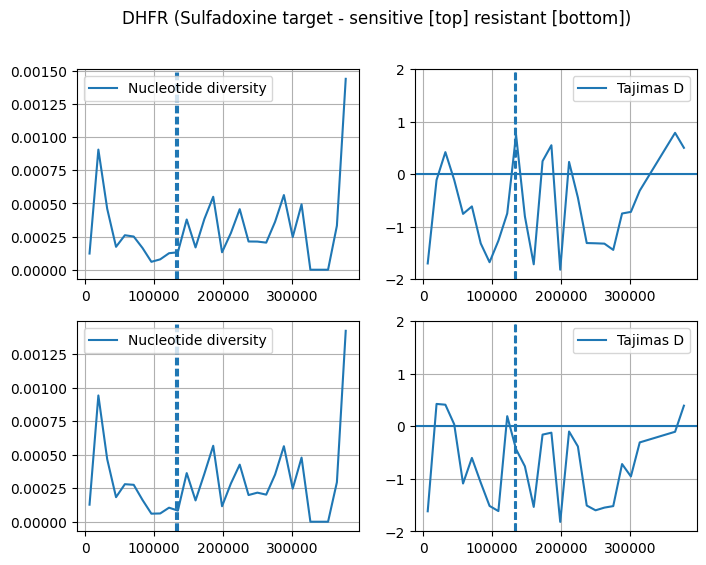

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

ax = axs[0][0]
sns.lineplot(x=mids, y=diversity_sens, ax=ax, label="Nucleotide diversity")

ax.axvline(747897-pos[0], ls='--')
ax.axvline(750065-pos[0], ls='--')
ax.grid(True)


ax = axs[0][1]
sns.lineplot(x=mids, y=tajima_sens, ax=ax, label="Tajimas D")

ax.set_ylim(-2, 2)
ax.axhline(0)
ax.axvline(747897-pos[0], ls='--')
ax.axvline(750065-pos[0], ls='--')
ax.grid(True)


ax = axs[1][0]
sns.lineplot(x=mids, y=diversity_res, ax=ax, label="Nucleotide diversity")

ax.axvline(747897-pos[0], ls='--')
ax.axvline(750065-pos[0], ls='--')
ax.grid(True)


ax = axs[1][1]
sns.lineplot(x=mids, y=tajima_res, ax=ax, label="Tajimas D")

ax.set_ylim(-2, 2)
ax.axhline(0)
ax.axvline(747897-pos[0], ls='--')
ax.axvline(750065-pos[0], ls='--')
ax.grid(True)

fig.suptitle("DHFR (Sulfadoxine target - sensitive [top] resistant [bottom])")